# Negative L1 norm prior experiment

This code attempts to learn the 4D prior
$J(x) = -||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i) = -t/2 - |x|$

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/NegL1_prior_4D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Negative L1 Norm J(x) = -||x||_1
    # S(x, t) = -t/2 - |x| (per dimension)
    # For n dimensions: S(x, t) = - (n*t)/2 - ||x||_1
    
    dim = y.shape[1]
    l1_norm = np.sum(np.abs(y), axis=1)
    return -(t) / 2.0 - l1_norm


def prior_true(y):
    # J(x) = -||x||_1
    return -np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Convex functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Convex functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions ($x_1$,0)',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}",fontsize=16)
        plt.xlabel('$x_1$',fontsize=16)
        plt.ylabel('Prior functions ($0,x_2$,0)',fontsize=16)
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 4

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 20000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 378.3979187011719
iteration 0 loss 558.5997924804688


iteration 5000 loss 0.023181874305009842


iteration 10000 loss 0.014648186974227428


iteration 15000 loss 0.009617568925023079


iteration 20000 loss 0.007278642151504755


iteration 25000 loss 0.0060829054564237595


iteration 30000 loss 0.0050528934225440025


iteration 35000 loss 0.004314401187002659


iteration 40000 loss 0.0040357583202421665


iteration 45000 loss 0.003332166699692607


iteration 50000 loss 0.0030336135532706976


iteration 55000 loss 0.0027934520039707422


iteration 60000 loss 0.002566629322245717


iteration 65000 loss 0.002333443844690919


iteration 70000 loss 0.0021266103722155094


iteration 75000 loss 0.0045506153255701065


iteration 80000 loss 0.0017874453915283084


iteration 85000 loss 0.002315848832949996


iteration 90000 loss 0.0015181617345660925


iteration 95000 loss 0.00139738863799721


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.001366912038065493


iteration 105000 loss 0.00128081941511482


iteration 110000 loss 0.0011842208914458752


iteration 115000 loss 0.0011157025583088398


iteration 120000 loss 0.0010553676402196288


iteration 125000 loss 0.0010030054254457355


iteration 130000 loss 0.0009561998303979635


iteration 135000 loss 0.0009196523460559547


iteration 140000 loss 0.0008823127718642354


iteration 145000 loss 0.0008500980329699814


iteration 150000 loss 0.00106272182893008


iteration 155000 loss 0.000794149178545922


iteration 160000 loss 0.0007689620833843946


iteration 165000 loss 0.0007458443869836628


iteration 170000 loss 0.0007243888103403151


iteration 175000 loss 0.0007042973884381354


iteration 180000 loss 0.0006859253044240177


iteration 185000 loss 0.0006684358813799918


iteration 190000 loss 0.0006522146286442876


iteration 195000 loss 0.0007137677748687565


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.000622559164185077


iteration 205000 loss 0.0006157644675113261


iteration 210000 loss 0.0006031665834598243


iteration 215000 loss 0.0005908692255616188


iteration 220000 loss 0.0005790109280496836


iteration 225000 loss 0.0005678260931745172


iteration 230000 loss 0.000556908780708909


iteration 235000 loss 0.0005470662144944072


iteration 240000 loss 0.000537108862772584


iteration 245000 loss 0.0005281554767861962


iteration 250000 loss 0.0005190456286072731


iteration 255000 loss 0.0005108457989990711


iteration 260000 loss 0.0005021017277613282


iteration 265000 loss 0.0004940618528053164


iteration 270000 loss 0.0004863174690399319


iteration 275000 loss 0.0004786172357853502


iteration 280000 loss 0.0004710037028416991


iteration 285000 loss 0.0004635363875422627


iteration 290000 loss 0.0004556011117529124


iteration 295000 loss 0.00044869937119074166


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0004422268830239773


iteration 305000 loss 0.00043879239819943905


iteration 310000 loss 0.00043185209506191313


iteration 315000 loss 0.0004251729988027364


iteration 320000 loss 0.0004187273734714836


iteration 325000 loss 0.0004124834085814655


iteration 330000 loss 0.00040671229362487793


iteration 335000 loss 0.0004008888208772987


iteration 340000 loss 0.00039535993710160255


iteration 345000 loss 0.0003900679002981633


iteration 350000 loss 0.00038470563595183194


iteration 355000 loss 0.00037963775685057044


iteration 360000 loss 0.0003745915601029992


iteration 365000 loss 0.00036983206518925726


iteration 370000 loss 0.0003651586885098368


iteration 375000 loss 0.0003604532976169139


iteration 380000 loss 0.00035598682006821036


iteration 385000 loss 0.000351671245880425


iteration 390000 loss 0.00034729635808616877


iteration 395000 loss 0.0003433394886087626


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.00033920223359018564


iteration 405000 loss 0.00033817626535892487


iteration 410000 loss 0.00033674799487926066


iteration 415000 loss 0.00033535671536810696


iteration 420000 loss 0.00033399174571968615


iteration 425000 loss 0.00033264493686147034


iteration 430000 loss 0.0003313165216241032


iteration 435000 loss 0.00033000577241182327


iteration 440000 loss 0.00032870887662284076


iteration 445000 loss 0.0003274254850111902


iteration 450000 loss 0.00032615623786114156


iteration 455000 loss 0.0003248961002100259


iteration 460000 loss 0.000323646207107231


iteration 465000 loss 0.0003224087995477021


iteration 470000 loss 0.0003211822477169335


iteration 475000 loss 0.0003199646598659456


iteration 480000 loss 0.00031875594868324697


iteration 485000 loss 0.0003175584424752742


iteration 490000 loss 0.0003163707151543349


iteration 495000 loss 0.0003151958517264575


L2 loss -- Plot

loss 90.76365661621094


loss 37.69656753540039


loss 9.349114418029785


loss -10.300454139709473


loss -22.713592529296875


loss -29.753389358520508


loss -33.5982666015625


loss -35.57331466674805


loss -36.44136047363281


loss -36.74135208129883


loss -36.81752014160156


loss -36.83073425292969


loss -36.83214569091797


loss -36.83222961425781


loss -36.832237243652344


loss -36.83222961425781


loss -36.83222579956055


loss -36.83222961425781


loss -36.832237243652344


loss -36.83222579956055


loss -36.83222961425781


loss -36.83222961425781


loss -36.83222198486328


loss -36.83222961425781


loss -36.83223342895508


loss -36.83222961425781


loss -36.83222961425781


loss -36.83222961425781


loss -36.83222961425781


loss -36.83222198486328


loss -36.83222961425781


loss -36.83223342895508


loss -36.83222579956055


loss -36.83222961425781


loss -36.83222961425781


loss -36.832237243652344


loss -36.83222198486328


loss -36.83222961425781


loss -36.83222961425781


loss -36.83222579956055


final mse:  2.579473878938643e-08
max, min: 3.0000217 -2.9931238
loss 90.76365661621094


loss 38.06496047973633


loss 9.425182342529297


loss -10.43682861328125


loss -22.672739028930664


loss -29.61446189880371


loss -33.46341323852539


loss -35.426414489746094


loss -36.27497863769531


loss -36.56829071044922


loss -36.64460372924805


loss -36.658390045166016


loss -36.659950256347656


loss -36.660057067871094


loss -36.66004943847656


loss -36.66005325317383


loss -36.66005325317383


loss -36.6600456237793


loss -36.660057067871094


loss -36.66005325317383


loss -36.66005325317383


loss -36.66004943847656


loss -36.66004943847656


loss -36.66005325317383


loss -36.660057067871094


loss -36.66005325317383


loss -36.660057067871094


loss -36.66006088256836


loss -36.66004943847656


loss -36.6600456237793


loss -36.66004943847656


loss -36.66005325317383


loss -36.66004943847656


loss -36.66004180908203


loss -36.66004943847656


loss -36.66004943847656


loss -36.66004943847656


loss -36.66004943847656


loss -36.66005325317383


loss -36.66005325317383


final mse:  1.9756079439048335e-08
max, min: 2.996844 -3.00006


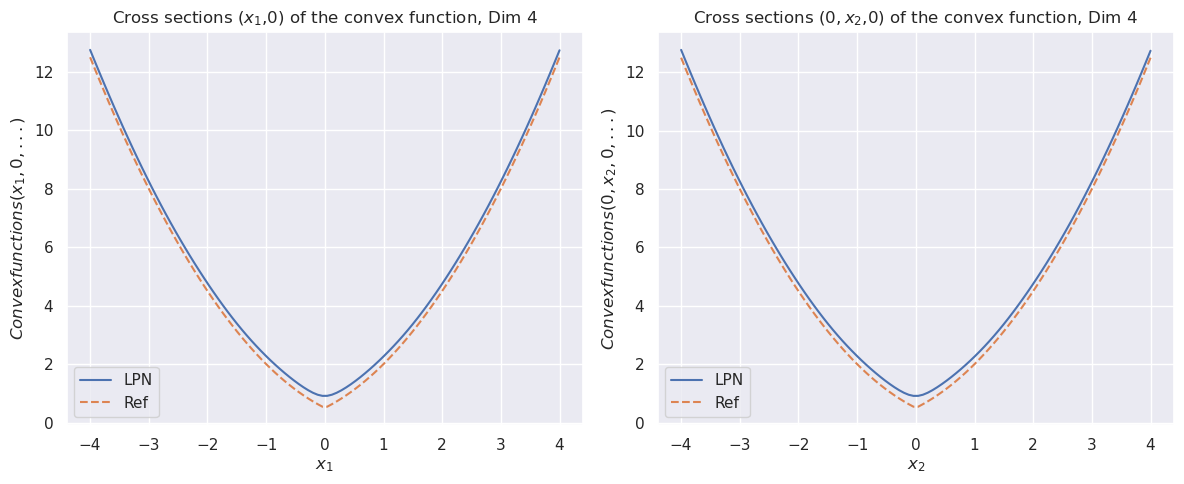

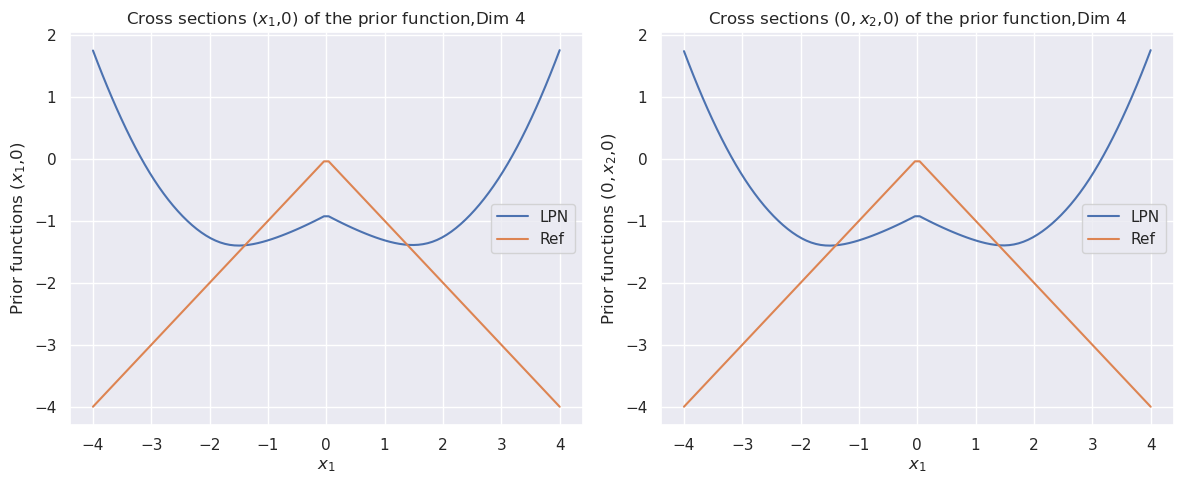

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 136.99209594726562
iteration 0 loss 1946.2760009765625


iteration 5000 loss 0.022796716541051865


iteration 10000 loss 0.007892929017543793


iteration 15000 loss 0.005280510522425175


iteration 20000 loss 0.0037931487895548344


iteration 25000 loss 0.004259258974343538


iteration 30000 loss 0.0026273359544575214


iteration 35000 loss 0.00264294957742095


iteration 40000 loss 0.0019650855101644993


iteration 45000 loss 0.0018972802208736539


iteration 50000 loss 0.0013791361125186086


iteration 55000 loss 0.0011709826067090034


iteration 60000 loss 0.0009844163432717323


iteration 65000 loss 0.0009816434467211366


iteration 70000 loss 0.0008225287892855704


iteration 75000 loss 0.0006854677922092378


iteration 80000 loss 0.000521975802257657


iteration 85000 loss 0.0004887621034868062


iteration 90000 loss 0.0007190045434981585


iteration 95000 loss 0.00047559087397530675


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0005815119366161525


iteration 105000 loss 0.00041199548286385834


iteration 110000 loss 0.000324540858855471


iteration 115000 loss 0.0002812243765220046


iteration 120000 loss 0.0002530993951950222


iteration 125000 loss 0.00023059200611896813


iteration 130000 loss 0.00021203412325121462


iteration 135000 loss 0.00019653973868116736


iteration 140000 loss 0.00018252419249620289


iteration 145000 loss 0.0001696584513410926


iteration 150000 loss 0.0001589719468029216


iteration 155000 loss 0.00014934208593331277


iteration 160000 loss 0.00038479286013171077


iteration 165000 loss 0.003408015239983797


iteration 170000 loss 0.00012528443767223507


iteration 175000 loss 0.00011848159920191392


iteration 180000 loss 0.0001119273147196509


iteration 185000 loss 0.00010545987606747076


iteration 190000 loss 9.932415559887886e-05


iteration 195000 loss 9.413099905941635e-05


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 8.916701335692778e-05


iteration 205000 loss 8.644141780678183e-05


iteration 210000 loss 8.2792503235396e-05


iteration 215000 loss 7.909301348263398e-05


iteration 220000 loss 7.581186946481466e-05


iteration 225000 loss 7.259110861923546e-05


iteration 230000 loss 6.979613681323826e-05


iteration 235000 loss 6.731501343892887e-05


iteration 240000 loss 6.496127025457099e-05


iteration 245000 loss 6.275970372371376e-05


iteration 250000 loss 6.085100176278502e-05


iteration 255000 loss 5.902757402509451e-05


iteration 260000 loss 5.735322702093981e-05


iteration 265000 loss 5.575256363954395e-05


iteration 270000 loss 5.429812517832033e-05


iteration 275000 loss 5.300348129821941e-05


iteration 280000 loss 5.183768007555045e-05


iteration 285000 loss 5.0735870900098234e-05


iteration 290000 loss 4.9688955186866224e-05


iteration 295000 loss 4.870008342550136e-05


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 4.779352821060456e-05


iteration 305000 loss 4.757128772325814e-05


iteration 310000 loss 4.6646575356135145e-05


iteration 315000 loss 4.5760047214571387e-05


iteration 320000 loss 4.4959211663808674e-05


iteration 325000 loss 4.423107748152688e-05


iteration 330000 loss 4.3520823965081945e-05


iteration 335000 loss 4.29425599577371e-05


iteration 340000 loss 4.230907143210061e-05


iteration 345000 loss 4.1734689148142934e-05


iteration 350000 loss 4.119852019357495e-05


iteration 355000 loss 4.066820474690758e-05


iteration 360000 loss 4.01963698095642e-05


iteration 365000 loss 3.969075987697579e-05


iteration 370000 loss 3.922332325601019e-05


iteration 375000 loss 3.876347909681499e-05


iteration 380000 loss 3.84028535336256e-05


iteration 385000 loss 3.796024975599721e-05


iteration 390000 loss 3.7584384699584916e-05


iteration 395000 loss 3.72316426364705e-05


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 3.689507502713241e-05


iteration 405000 loss 3.6812180042034015e-05


iteration 410000 loss 3.647789708338678e-05


iteration 415000 loss 3.61328711733222e-05


iteration 420000 loss 3.5800225305138156e-05


iteration 425000 loss 3.5478620702633634e-05


iteration 430000 loss 3.5167220630683005e-05


iteration 435000 loss 3.486510831862688e-05


iteration 440000 loss 3.457132334006019e-05


iteration 445000 loss 3.4285170841030777e-05


iteration 450000 loss 3.400513014639728e-05


iteration 455000 loss 3.3731237635947764e-05


iteration 460000 loss 3.3464108128100634e-05


iteration 465000 loss 3.3202341001015157e-05


iteration 470000 loss 3.294557973276824e-05


iteration 475000 loss 3.269390435889363e-05


iteration 480000 loss 3.244711842853576e-05


iteration 485000 loss 3.2205338357016444e-05


iteration 490000 loss 3.196838952135295e-05


iteration 495000 loss 3.173540244461037e-05


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


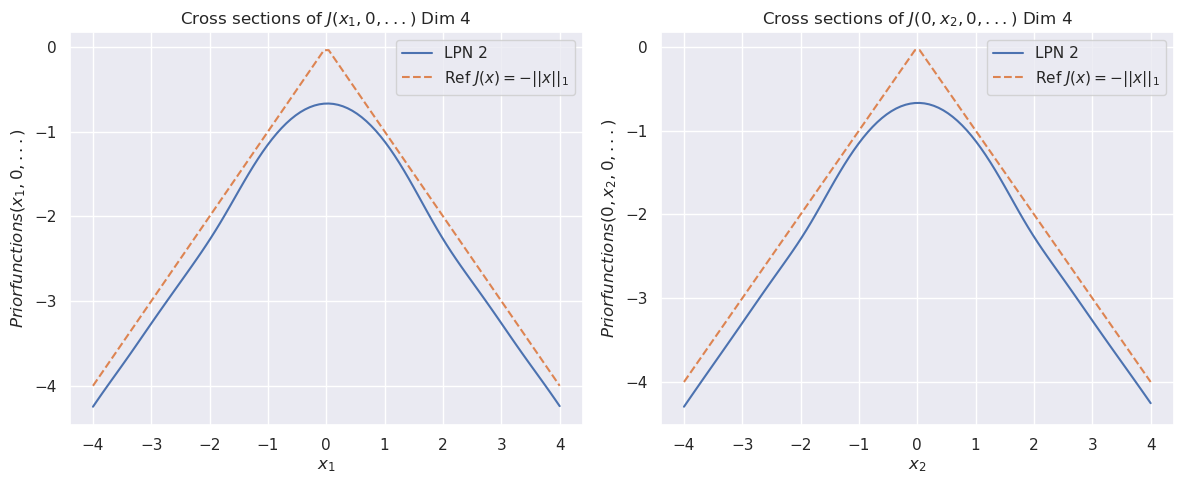

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Prior functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)